# An Overview of a regression assignment 
Attempting to fit house prices, using the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 
Based on a [tutorial](https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea) by Mauro Di Pietro

### 0. Imports

In [49]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")


### 1. Introducing the House prices dataset -- Exploratory Data Analysis (EDA)
##### The goal of this phase is to understand the different features and relations between them and w.r.t. the target feature

Loading the CSV dataset

In [50]:
dtf = pd.read_csv("./data/data_houses.csv",index_col='Id')

In [51]:
cols = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","FullBath","YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass", "SalePrice"]
dtf = dtf[cols]

In [52]:
dtf.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


In [53]:
dtf.describe()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,472.980137,1057.429452,1.565068,1971.267808,1984.865753,70.049958,56.897260,180921.195890
std,1.382997,525.480383,0.747315,213.804841,438.705324,0.550916,30.202904,20.645407,24.284752,42.300571,79442.502883
min,1.000000,334.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,1950.000000,21.000000,20.000000,34900.000000
25%,5.000000,1129.500000,1.000000,334.500000,795.750000,1.000000,1954.000000,1967.000000,59.000000,20.000000,129975.000000
50%,6.000000,1464.000000,2.000000,480.000000,991.500000,2.000000,1973.000000,1994.000000,69.000000,50.000000,163000.000000
75%,7.000000,1776.750000,2.000000,576.000000,1298.250000,2.000000,2000.000000,2004.000000,80.000000,70.000000,214000.000000
max,10.000000,5642.000000,4.000000,1418.000000,6110.000000,3.000000,2010.000000,2010.000000,313.000000,190.000000,755000.000000


#### Examining the target feature - "SalePrice": Using a histogram, a KDE plot, and a box plot

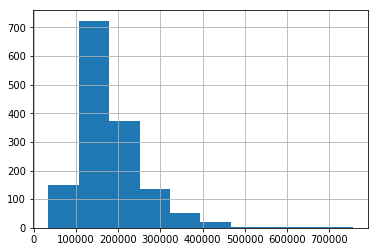

In [54]:
dtf.SalePrice.hist()

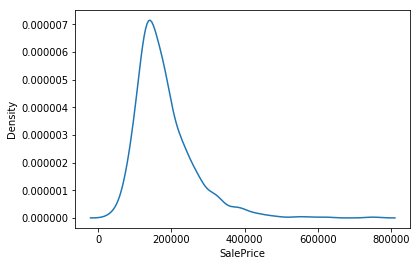

In [55]:
sns.kdeplot(dtf.SalePrice)

We suspect that there is a long tail, therefore we may have outliers. This is better demonstrated in a box plote:

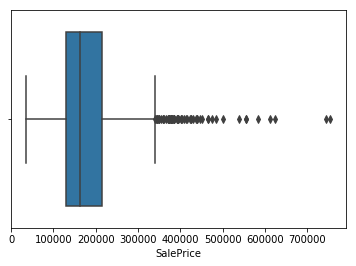

In [56]:
sns.boxplot(dtf.SalePrice)

#### Examining Correlations to the target feature:

In [57]:
dtf_corr = dtf.corr(method="pearson").loc[["SalePrice"]]

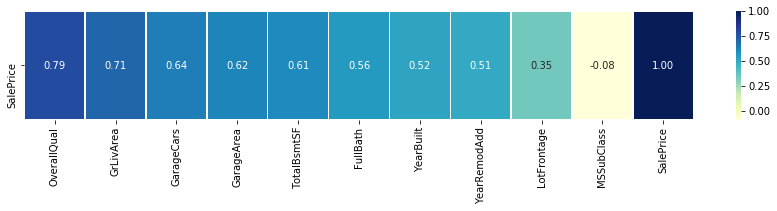

In [58]:
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


#### Visualzing relevant feature-pair relations:

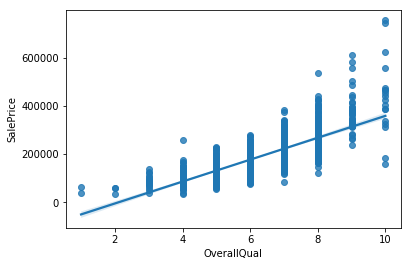

In [59]:
sns.regplot(data=dtf,x='OverallQual',y='SalePrice')

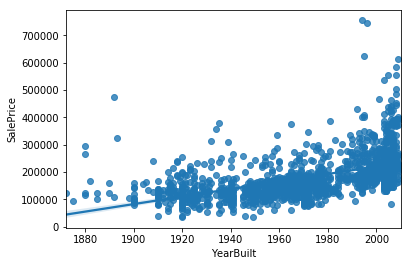

In [60]:
sns.regplot(data=dtf,x='YearBuilt',y='SalePrice')

While the plot above is difficult to read, we can bin the year column then group by and view the mean price

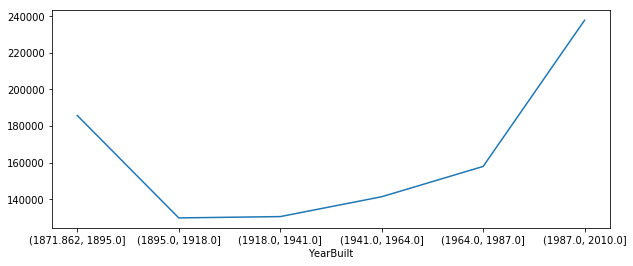

In [61]:
fig, ax = plt.subplots(figsize=(10,4))
dtf.groupby(pd.cut(dtf['YearBuilt'],6))['SalePrice'].mean().plot(kind='line',ax=ax)

### 2 - Cleaning and Preprocessing

A. Split to Train and Test, then see the target feature distributions:

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
dtf_train, dtf_test = train_test_split(dtf, 
                      test_size=0.25)

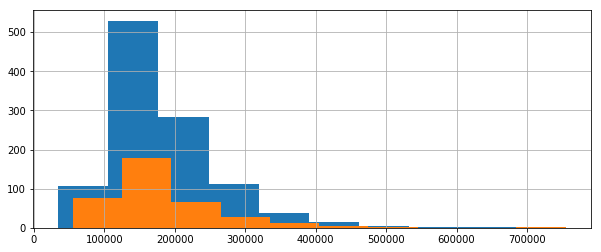

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
dtf_train.SalePrice.hist(ax=ax)
dtf_test.SalePrice.hist(ax=ax)

B. Fill Null values:

In [65]:
dtf_train.isna().sum()

OverallQual       0
GrLivArea         0
GarageCars        0
GarageArea        0
TotalBsmtSF       0
FullBath          0
YearBuilt         0
YearRemodAdd      0
LotFrontage     187
MSSubClass        0
SalePrice         0
dtype: int64

In [66]:
dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())
dtf_test["LotFrontage"] = dtf_test["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())


C. "One hot encoding" for categorical variables.<br> While all features seem numeric, some of them are not! 

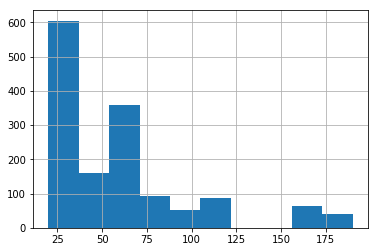

In [67]:
dtf.MSSubClass.hist()

This looks like a numeric features, but if we show the distinct value count:

In [68]:
vc = dtf_train.MSSubClass.value_counts()

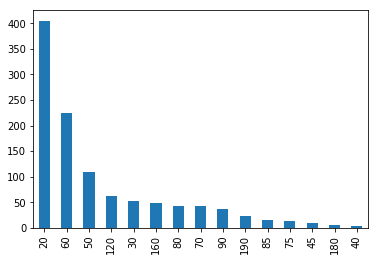

In [69]:
vc.plot(kind='bar')

Too many categories ==> Too many features. We can group the insignificant categories together:

In [70]:
low_categories = vc[vc <50]

In [71]:
new_col_train = dtf_train.MSSubClass.apply(lambda x: 5000 if x in low_categories else x )
new_col_test = dtf_test.MSSubClass.apply(lambda x: 5000 if x in low_categories else x )

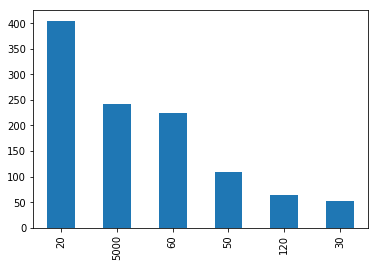

In [72]:
new_col_train.value_counts().plot(kind='bar')

In [73]:
dummy_train = pd.get_dummies(new_col_train, prefix="MSSubClass")
dummy_test = pd.get_dummies(new_col_test, prefix="MSSubClass")


Do our new features have any correlation with the target feature?

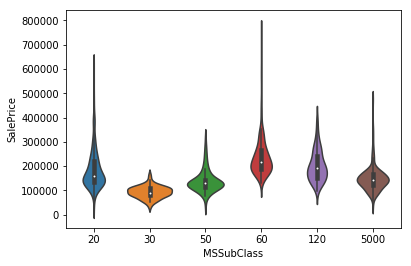

In [74]:
sns.violinplot(x=new_col_train,y=dtf_train.SalePrice)

A violin plot shows a KDE plot for each category. We can compare both the peaks and the overall value distribution

Concat the one-hot attributes and drop the original

In [75]:
dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
dtf_test = pd.concat([dtf_test, dummy_test], axis=1)

In [76]:
dtf_train = dtf_train.drop("MSSubClass", axis=1)
dtf_test = dtf_test.drop("MSSubClass", axis=1)


### 3. Create a Baseline Regression Model

In [77]:
from sklearn.linear_model import LinearRegression

In [78]:
#separate X from y
X_train = dtf_train.drop('SalePrice',axis=1)
X_test = dtf_test.drop('SalePrice',axis=1)

y_train = dtf_train['SalePrice']
y_test = dtf_test['SalePrice']




#### Train a linear regression model

In [79]:
model = LinearRegression()

In [80]:
prediction = model.fit(X_train,y_train).predict(X_test)

### 4. Evaluate how good is the model

Many metrics exist for evaluating the regression over the test data. 


In [81]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

Let's start with r^2: R Squared is the squared sum of differences from the actual values and the predicted values, divided by the squared differences from the mean (i.e var*n)

In [82]:
r2_score(y_test,prediction)

0.7879303070660273

<br> What is a good R2 score and how do we improve it? This is not an ML class, a better question is what does the score "means"
<br>
High R2 means that the model "explains" a lot of the variance, i.e. that the behaviour is "predicted".
It *doesn't* directly imply whether the model is right!
<br>
Let's see more metrics:

In [108]:
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, prediction))))

## residuals
residuals = y_test - prediction
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]
#max_true, max_pred = y_test.loc[max_idx], prediction[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.154
Mean Absolute Error (Σ|y - pred|/n): 25,508
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 37,070
Max Error: 294,719


We now plot the true values against the predicted values. 
<br> In the regression line, the predicted values are always on the function y=x

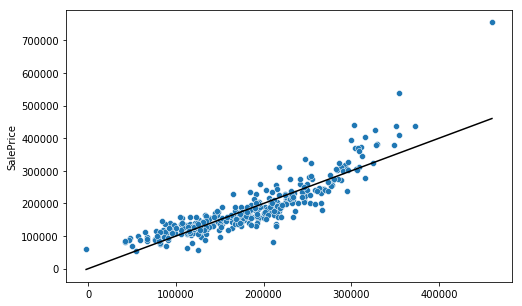

In [109]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(prediction,y_test,ax=ax)
sns.lineplot(prediction,prediction,ax=ax,color='black')

We can already learn that our bigger mistakes are when the sale price is larger.
<br>
Lets take a deeper looks into the 'residuals'

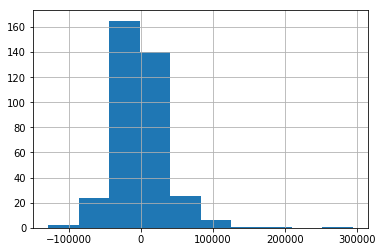

In [110]:
residuals.hist()

Text(0.5, 1.0, 'Residuals (%)')

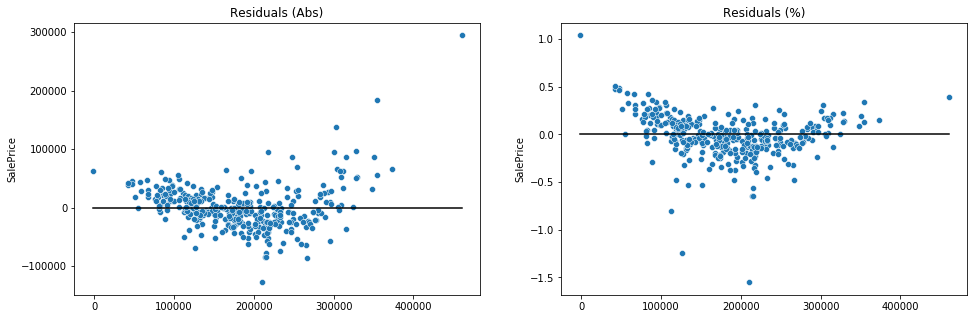

In [111]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(prediction,residuals,ax=ax[0])
sns.lineplot(prediction,0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
sns.scatterplot(prediction,residuals/y_test,ax=ax[1])
sns.lineplot(prediction,0,ax=ax[1],color='black')
ax[1].set_title("Residuals (%)")

So we can see that we have "small" mistakes and "big" mistakes. Let's look into that:

In [112]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

How many time did our model achieve low estimation error (error less than 5%)?:

In [113]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.2356164383561644

How about more than 20%?

In [114]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.25205479452054796

### 4. Model Explainability

We are first interested in feature importance.
<br>
In the simple linear regression model, we can look at the learned coefficients:

In [149]:
print("Model coefficients:\n")
for i in range(len(X_train.columns)):
    print(X_train.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

OverallQual = 20586.0709
GrLivArea = 62.155
GarageCars = 11741.5742
GarageArea = 7.4286
TotalBsmtSF = 15.5036
FullBath = -7705.1308
YearBuilt = 378.4061
YearRemodAdd = 260.5267
LotFrontage = -184.1707
MSSubClass_20 = 17390.0647
MSSubClass_50 = 8759.2118
MSSubClass_60 = 53.4118
MSSubClass_70 = 4672.9196
MSSubClass_120 = -6401.9222
MSSubClass_160 = -31189.3327
MSSubClass_5000 = 6715.647


However, since our features are not normalized, it is hard to assess which ones are the most important.
<br>
For that, we use SHAP

In [116]:
import shap

In [117]:
shap_sample = X_train.sample(500)

In [118]:
explainer = shap.Explainer(model.predict, shap_sample)
shap_values = explainer(shap_sample)

Permutation explainer: 501it [00:12,  8.51it/s]                         


In [119]:
dtf.columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       'FullBath', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'MSSubClass',
       'SalePrice'],
      dtype='object')

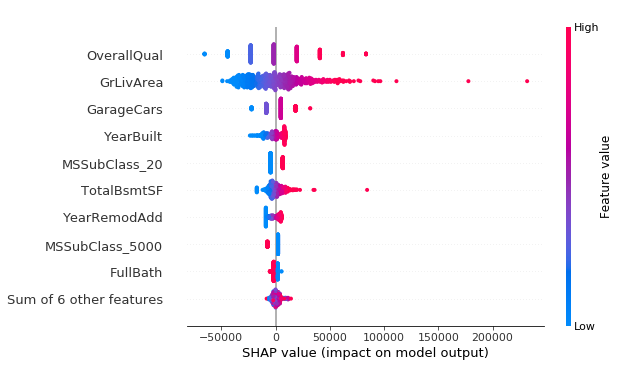

In [120]:
shap.plots.beeswarm(shap_values)

Remember that we can also do that to explain the prediction of a single element:

In [121]:
test_shap_values = explainer(X_test)

What was our biggest relative error?

In [128]:
rel_res[rel_res==rel_res.max()]


Id
633    1.551585
Name: SalePrice, dtype: float64

Our model predicted:

In [129]:
max_id = rel_res[rel_res==rel_res.max()].index[0]
pred_series=pd.Series(prediction,index=rel_res.index)
pred_series[max_id]

210505.79890024918

And the real price was:

In [132]:
y_test[max_id]

82500

Let's look at this problematic point:

In [134]:
X_test.loc[max_id]


OverallQual           7.0
GrLivArea          1411.0
GarageCars            2.0
GarageArea          544.0
TotalBsmtSF        1386.0
FullBath              2.0
YearBuilt          1977.0
YearRemodAdd       1977.0
LotFrontage          85.0
MSSubClass_20         1.0
MSSubClass_30         0.0
MSSubClass_50         0.0
MSSubClass_60         0.0
MSSubClass_120        0.0
MSSubClass_5000       0.0
Name: 633, dtype: float64

In [138]:
max_ordinal_id= X_test.index.get_loc(max_id)

In [135]:
#sns.boxenplot(dtf.GrLivArea)

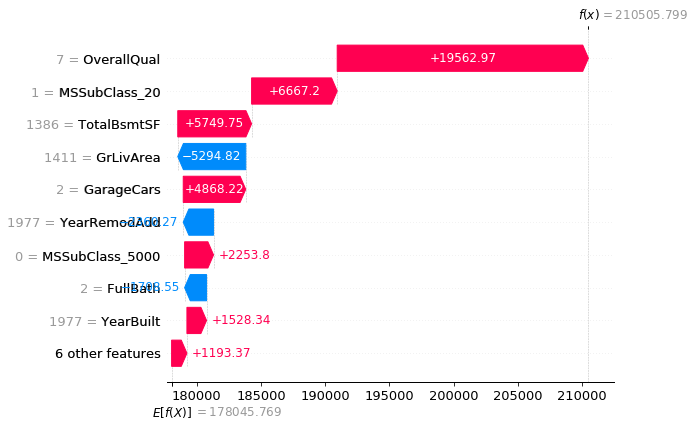

In [141]:
shap.plots.waterfall(test_shap_values[max_ordinal_id])

In [142]:
len(residuals[residuals>50000])

24

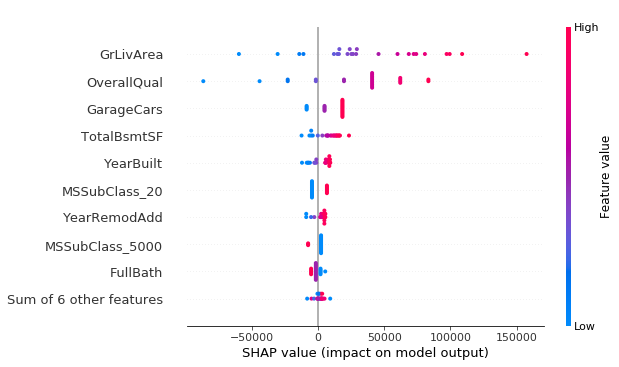

In [143]:
bad_examples = X_test.loc[residuals[residuals>50000].index]
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)

To get even a deeper understanding regarding our model's mistakes, we can compare the distributions of our mistakes to good predictions

In [144]:
over_estimates = X_test.loc[residuals[residuals>50000].index]

In [145]:
good_estimates = X_test.loc[rel_res[rel_res<0.05].index]

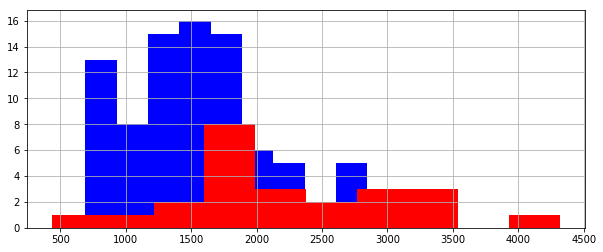

In [146]:
fig, ax = plt.subplots(figsize=(10,4))
good_estimates.GrLivArea.hist(ax=ax,color='blue')
over_estimates.GrLivArea.hist(ax=ax,color='red')

We can see that our overestimas contains "larger" apartments.
<br> While the model correctly understood that larger apartments are often more expensive, this is not always correct! 

In [149]:
len(good_estimates)

86

In [150]:
len(over_estimates)

24